<a href="https://colab.research.google.com/github/aarondardik/aarondardik.github.io/blob/main/CS567_NN_modified_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NN with keras for classifiying damage grade  to buildings

Setup:
Select Runtime from the menu and Change the runtime type. Choose GPU from the Hardware accelerator options - click save

multi-class
output- damage grade (1,2,3)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd



In [47]:
from google.colab import drive
drive.mount('/content/drive')

# convert csv to dataframe
x = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/567_Data/train_values.csv',index_col='building_id')
y = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/567_Data/train_labels.csv',index_col='building_id')
x_comp_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/567_Data/test_values.csv',index_col='building_id')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# select features

selected_features = ['geo_level_1_id',
                    'geo_level_2_id',
                    'geo_level_3_id',
                    'count_floors_pre_eq',
                     'age',
                     'area_percentage', 
                     'height_percentage',
                     'land_surface_condition',
                     'foundation_type',
                     'roof_type',
                     'ground_floor_type',
                     'position',
                     'plan_configuration',
                     'legal_ownership_status',
                     'count_families'
                     ]

selected_features_1 = ['count_floors_pre_eq',
                     'area_percentage', 
                     'height_percentage',
                     'land_surface_condition',
                     'foundation_type',
                     'roof_type',
                     'ground_floor_type',
                     'position',
                     'plan_configuration',
                     'has_superstructure_adobe_mud',
                     'has_superstructure_mud_mortar_stone',
                     'has_superstructure_stone_flag',
                     'has_superstructure_cement_mortar_stone',
                     'has_superstructure_mud_mortar_brick',
                     'has_superstructure_cement_mortar_brick',
                     'has_superstructure_timber',
                     'has_superstructure_bamboo',
                     'has_superstructure_rc_non_engineered',
                     'has_superstructure_rc_engineered',
                     'has_superstructure_other',
                     'legal_ownership_status',
                     'count_families',
                     'has_secondary_use',
                     'has_secondary_use_agriculture',
                     'has_secondary_use_hotel',
                     'has_secondary_use_rental',
                     'has_secondary_use_institution'
                     ]


x_subfeatures = x[selected_features]
x_comp_test_subfeatures = x_comp_test[selected_features]
#if want all features
#x_subfeatures =x
display(x.shape)
display(x_subfeatures.shape)


(260601, 38)

(260601, 15)

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif


from sklearn.metrics import f1_score, classification_report


from timeit import default_timer as timer

In [50]:
# get the categorical and numeric column names
numerical = x_subfeatures.select_dtypes(include=['number']).columns.tolist()
categorical = x_subfeatures.select_dtypes(exclude=['number']).columns.tolist()

#pipeline numerical columns

num_pipe = Pipeline ([
  ('num_imputer', SimpleImputer (strategy= 'median')),
  ('num_scaler', StandardScaler())
])

#pipeline for categorical features
#set to encode all nomial columns, use onehotencoder with all values since there didnt look like alot of categories in each
cat_pipe = Pipeline ([
  ('cat_imputer', SimpleImputer (strategy= 'constant', fill_value ='n/a')),
  ('cat_encoder',  OneHotEncoder())
])


# Fit column transformer to training data
preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('cat', cat_pipe, categorical)
])

preprocessor.fit_transform(x_subfeatures)

#prepare label data-> convert to binary
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()


# prepare column names
cat_columns = preprocessor.named_transformers_['cat']['cat_encoder'].get_feature_names_out(categorical)
columns = np.append(cat_columns, numerical) 

# Inspect training data before and after
print("******************** Training data ********************")
display(x_subfeatures)
display(pd.DataFrame(preprocessor.transform(x_subfeatures), columns=columns))
x_subfeatures= preprocessor.transform(x_subfeatures)


******************** Training data ********************


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,position,plan_configuration,legal_ownership_status,count_families
building_id,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,t,d,v,1
28830,8,900,2812,2,10,8,7,o,r,n,x,s,d,v,1
94947,21,363,8973,2,10,5,5,t,r,n,f,t,d,v,1
590882,22,418,10694,2,10,6,5,t,r,n,f,s,d,v,1
201944,11,131,1488,3,30,8,9,t,r,n,f,s,d,v,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,f,s,q,v,1
669485,17,715,2060,2,0,6,5,t,r,n,f,s,d,v,1
602512,17,51,8163,3,55,6,7,t,r,q,f,s,d,v,1


,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,...,legal_ownership_status_v,legal_ownership_status_w,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0.038365,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,1.381653,1.536007,-1.271644,-1.552536,0.386932,-0.459460,-1.268946,0.038365,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
260597,0.385835,0.033741,-1.151250,-0.178274,-0.360698,-0.459460,-0.226419,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
260598,0.385835,-1.575137,0.522472,1.195989,0.386932,-0.459460,0.816109,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
260599,1.506130,-1.604213,-1.208568,-0.178274,-0.224765,1.361941,0.294845,0.038365,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [51]:
x_comp_test =  preprocessor.transform(x_comp_test_subfeatures)

In [52]:
x_train_subset= x_subfeatures
y_train_subset= y

# is this doing something wrong-> accuracy sits .5 so random guess
#x_train_subset, x_test_subset, y_train_subset, y_test_subset = train_test_split( x_subfeatures, y, train_size=0.90, random_state=4)

display(x_train_subset.shape)
display(y.shape)


(260601, 42)

(260601, 3)

In [53]:
from keras.layers.regularization.dropout import Dropout
# build  NN
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense

initial_learning_rate = 0.1



layer_nuerons = [np.shape(x_train_subset)[1], 15, 3 ]
layer_activ = {0:'relu', 1:'tanh', 2:'softmax'}

# Neural network
model = Sequential()
model.add(Dense(layer_nuerons[0], input_dim= np.shape(x_train_subset)[1], activation= layer_activ[0]))

model.add(Dense(layer_nuerons[1], activation=layer_activ[1]))
model.add(Dropout(0.3))

model.add(Dense(layer_nuerons[2], activation=layer_activ[2]))

##model.add(Dense(layer_nuerons[3], activation=layer_activ[3]))
##model.add(Dropout(0.3))

##model.add(Dense(layer_nuerons[4], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer= keras.optimizers.SGD(learning_rate=initial_learning_rate),
              metrics=['accuracy'])

In [54]:
#train model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow import keras

##model.summary()
#early stop for large number of epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience =50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.fit(x_train_subset, y_train_subset, validation_split = 0.1, epochs=2, batch_size=16, callbacks =[es,mc])
model.fit(x_train_subset, y_train_subset, validation_split = 0.1, epochs=25, batch_size=32, callbacks =[es,mc])
history = model.fit(x_train_subset, y_train_subset, validation_split = 0.1, epochs=50, batch_size=64, callbacks =[es,mc])

saved_model = keras.models.load_model('best_model.h5')
saved_model.save('/content/drive/My Drive/Colab Notebooks/cats-vs-dogs/CSCI567_nn_model.h5')

Epoch 1/2
14659/14659 [==============================] - ETA: 0s - loss: 0.7985 - accuracy: 0.5997
Epoch 1: val_accuracy improved from -inf to 0.61859, saving model to best_model.h5
14659/14659 [==============================] - 28s 2ms/step - loss: 0.7985 - accuracy: 0.5997 - val_loss: 0.7846 - val_accuracy: 0.6186
Epoch 2/2
14625/14659 [============================>.] - ETA: 0s - loss: 0.7832 - accuracy: 0.6149
Epoch 2: val_accuracy improved from 0.61859 to 0.63125, saving model to best_model.h5
14659/14659 [==============================] - 29s 2ms/step - loss: 0.7831 - accuracy: 0.6150 - val_loss: 0.7700 - val_accuracy: 0.6312
Epoch 1/25
7319/7330 [============================>.] - ETA: 0s - loss: 0.7644 - accuracy: 0.6334
Epoch 1: val_accuracy did not improve from 0.63125
7330/7330 [==============================] - 14s 2ms/step - loss: 0.7644 - accuracy: 0.6334 - val_loss: 0.7653 - val_accuracy: 0.6177
Epoch 2/25
7319/7330 [============================>.] - ETA: 0s - loss: 0.7582

In [55]:
# predict and test

y_pred = saved_model.predict(x_train_subset)


#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_train_subset)):
    test.append(np.argmax(y_train_subset[i]))

score = f1_score(test, pred, average='micro')
print("NN Score  f1 score: %.3f" %  score)



8144/8144 [==============================] - 11s 1ms/step
NN Score  f1 score: 0.670


8144/8144 [==============================] - 14s 2ms/step
NN Score f1 score: 0.712

In [56]:
for key in history.history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


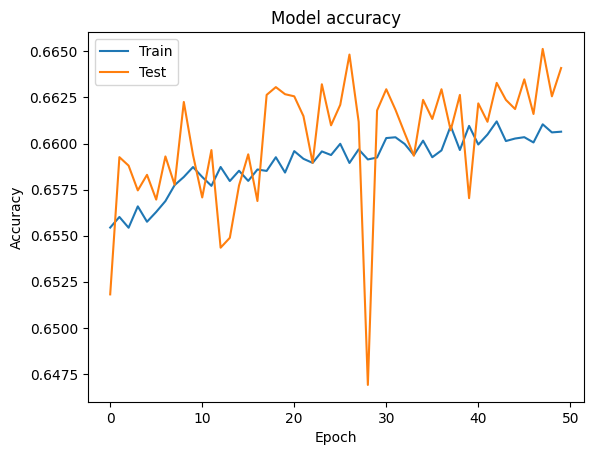

In [57]:
#view model accuracy 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

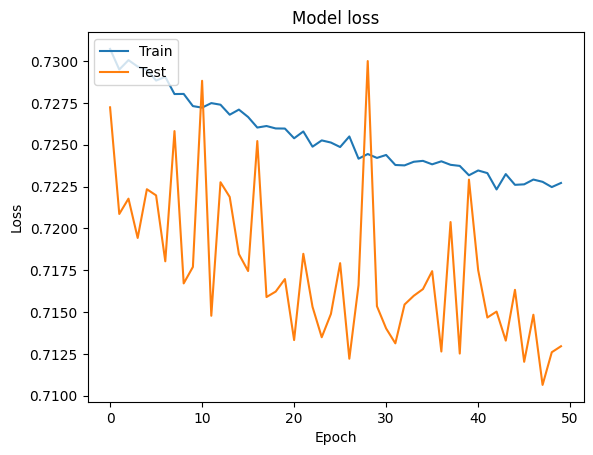

In [58]:
#view model loss
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [60]:
#make predicitions and set to submission format

y_submit_pred = saved_model.predict(x_comp_test)


#Converting predictions to label
submit_pred = list()
for i in range(len(y_submit_pred)):
    submit_pred.append(np.argmax(y_submit_pred[i]))


submission_format = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/567_Data/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=submit_pred,
                             columns=submission_format.columns,
                             index=submission_format.index)

my_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/567_Data/submission.csv')
!head '/content/drive/MyDrive/Colab Notebooks/567_Data/submission.csv'

2715/2715 [==============================] - 3s 1ms/step
building_id,damage_grade
300051,2
99355,1
890251,1
745817,1
421793,2
871976,1
691228,0
896100,2
343471,1
